In [198]:
from yfinance import download
from numpy import where, nan
from pandas import isna
from sklearn.tree import DecisionTreeClassifier
from graficos import *
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# PREDIÇÃO DE DADOS BINÁRIOS

Predição da série dos retornos de ativos financeiros

### Dados

In [147]:
ticker = 'AZUL4.SA'
start = '2017-05-12'
end = '2023-05-12'
column_variacao_percentual = 'Adj Close'
periodos_alvo = 1

In [148]:
df_price = download(ticker, start, end, progress=False)
df_price

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AZUL4.SA,AZUL4.SA,AZUL4.SA,AZUL4.SA,AZUL4.SA,AZUL4.SA
Date,,,,,,
2017-05-12,25.250000,25.250000,25.790001,24.900000,25.790001,155600
2017-05-15,25.680000,25.680000,26.690001,25.360001,26.690001,1205200
2017-05-16,26.299999,26.299999,26.299999,25.700001,25.889999,768700
2017-05-17,26.500000,26.500000,26.900000,26.000000,26.340000,1085600
2017-05-18,22.719999,22.719999,24.139999,21.760000,23.000000,829700
...,...,...,...,...,...,...
2023-05-05,11.630000,11.630000,11.840000,11.230000,11.440000,12975800
2023-05-08,11.720000,11.720000,12.110000,11.650000,11.710000,9554900


A ``variação percentual`` será utilizada para derivar variáveis de entrada que alimentam o modelo de aprendizado de máquina, auxiliando na identificação de padrões nos dados.

![alt text](Screenshot_1.png)

In [149]:
df_price['variacao_percentual'] = df_price[column_variacao_percentual].pct_change(periodos_alvo)
df_price.tail(2)

Price,Adj Close,Close,High,Low,Open,Volume,variacao_percentual
Ticker,AZUL4.SA,AZUL4.SA,AZUL4.SA,AZUL4.SA,AZUL4.SA,AZUL4.SA,
Date,,,,,,,
2023-05-10,12.29,12.29,12.33,11.75,11.75,15418500,0.04418
2023-05-11,12.97,12.97,13.03,12.25,12.31,18203600,0.05533


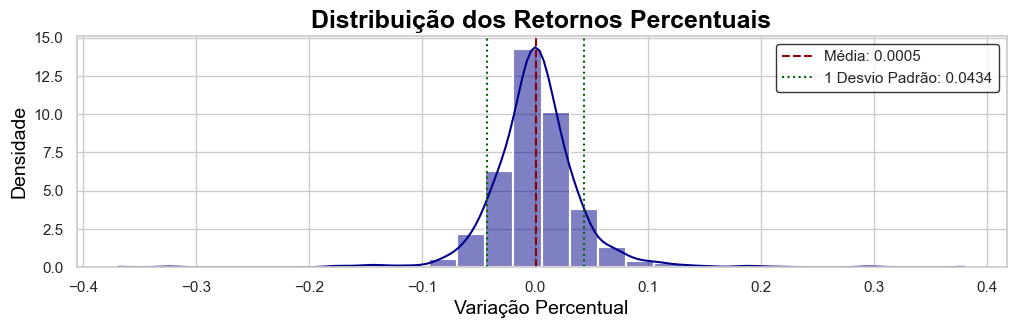

In [150]:
grafico_KDE(df_price, 'variacao_percentual', title='Distribuição dos Retornos Percentuais', xlabel='Variação Percentual')

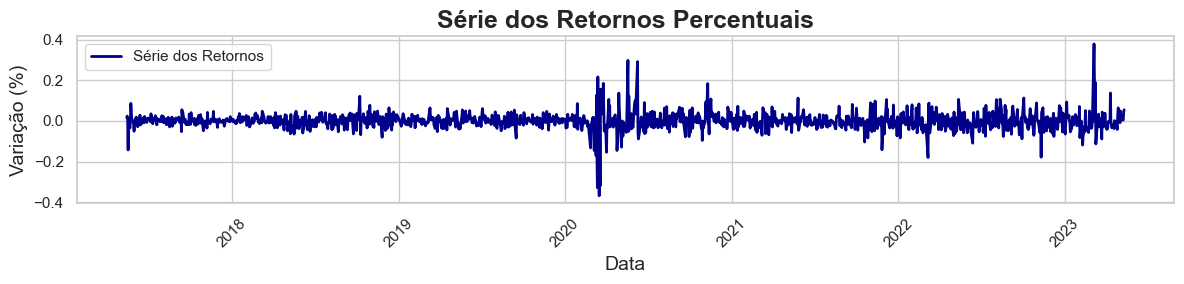

In [151]:
grafico_linha(df_price, 'variacao_percentual', 'Série dos Retornos Percentuais', 'Data', 'Variação (%)', label='Série dos Retornos')

Estou criando uma nova variável, `'alvo_numerico'`, que representa a diferença entre o preço de fechamento e o de abertura. Em seguida, desloca essa coluna para cima, preparando os dados para um modelo que utilizará a variação futura como "alvo" (o que o modelo tentará prever).

O último dado da coluna `'alvo_numerico'` é `NaN`, pois não existe um valor referente ao próximo dia para realizar o deslocamento.

In [152]:
df_price['alvo_numerico'] = df_price['Close'] - df_price['Open']
df_price['alvo_numerico'] = df_price['alvo_numerico'].shift(-periodos_alvo)
df_price.tail(3)

Price,Adj Close,Close,High,Low,Open,Volume,variacao_percentual,alvo_numerico
Ticker,AZUL4.SA,AZUL4.SA,AZUL4.SA,AZUL4.SA,AZUL4.SA,AZUL4.SA,,
Date,,,,,,,,
2023-05-09,11.77,11.77,11.99,11.57,11.67,11598000,0.004266,0.54
2023-05-10,12.29,12.29,12.33,11.75,11.75,15418500,0.044180,0.66
2023-05-11,12.97,12.97,13.03,12.25,12.31,18203600,0.055330,NaN


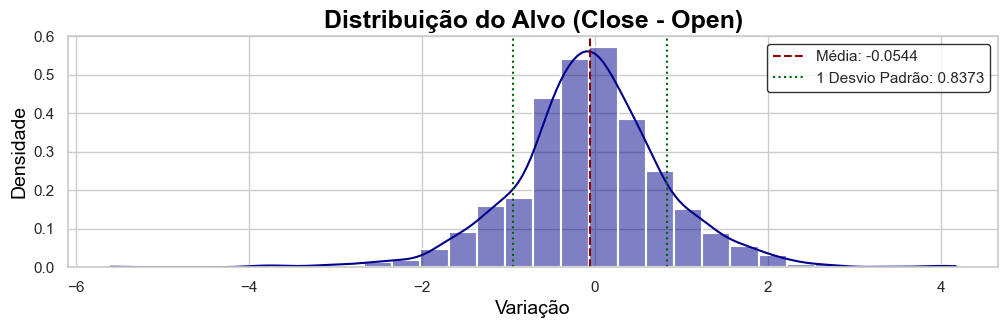

In [153]:
grafico_KDE(df_price, 'alvo_numerico', title='Distribuição do Alvo (Close - Open)', xlabel='Variação')

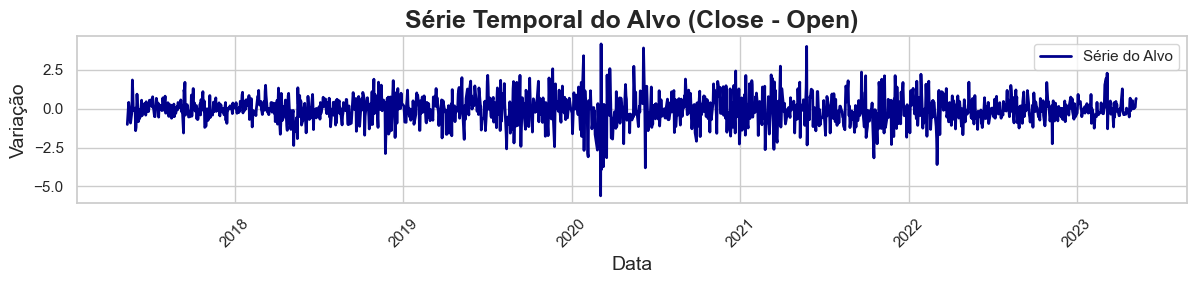

In [154]:
grafico_linha(df_price, 'alvo_numerico', title='Série Temporal do Alvo (Close - Open)', xlabel='Data', ylabel='Variação', label='Série do Alvo')

Ou seja, a previsão é realizada com base nos dados do dia anterior, e o alvo será o preço de fechamento do dia seguinte.



In [155]:
df_alvo_explicativo = df_price.copy()
df_alvo_explicativo = df_alvo_explicativo.reset_index()
df_alvo_explicativo['Date'] = df_alvo_explicativo['Date'].astype(str)
df_alvo_explicativo['variacao_numerica'] = df_alvo_explicativo['Close'] - df_alvo_explicativo['Open']
df_alvo_explicativo['alvo_numerico_e_data'] = (df_alvo_explicativo['variacao_numerica'].astype(str) + ' | ' + df_alvo_explicativo['Date'])
df_alvo_explicativo['alvo_numerico_e_data'] = df_alvo_explicativo['alvo_numerico_e_data'].shift(-periodos_alvo)
df_alvo_explicativo[['Date', 'Open', 'Close', 'variacao_percentual', 'alvo_numerico', 'alvo_numerico_e_data']].tail(3)


Price,Date,Open,Close,variacao_percentual,alvo_numerico,alvo_numerico_e_data
Ticker,,AZUL4.SA,AZUL4.SA,,,
1491,2023-05-09,11.67,11.77,0.004266,0.54,0.5399999618530273 | 2023-05-10
1492,2023-05-10,11.75,12.29,0.044180,0.66,0.6599998474121094 | 2023-05-11
1493,2023-05-11,12.31,12.97,0.055330,NaN,None


O cálculo do retorno real será feito com base na diferença entre o preço de abertura (Open) e o preço de fechamento (Close), em vez de utilizar a variação percentual.

Quando o valor de `alvo_numerico` para o próximo dia é `NaN` (por exemplo, quando não há dados disponíveis para o dia seguinte), eu considero que a previsão não é válida. Nesse caso, eu também defino o valor de `alvo_binario` como `NaN`, pois a previsão não pode ser feita adequadamente.

Se eu não fizer essa alteração, ao calcular o retorno real, o valor `NaN` no `np.where()` será considerado como `0`, o que pode gerar uma previsão errada ou inválida.

In [156]:
df_price['alvo_binario'] = where(df_price['alvo_numerico'] > 0, 1, 0)

if isna(df_price.iloc[-1, df_price.columns.get_loc('alvo_numerico')]).item():
    df_price.iloc[-1, df_price.columns.get_loc('alvo_numerico')] = nan
    df_price.iloc[-1, df_price.columns.get_loc('alvo_binario')] = nan

df_price.tail(3)

Price,Adj Close,Close,High,Low,Open,Volume,variacao_percentual,alvo_numerico,alvo_binario
Ticker,AZUL4.SA,AZUL4.SA,AZUL4.SA,AZUL4.SA,AZUL4.SA,AZUL4.SA,,,
Date,,,,,,,,,
2023-05-09,11.77,11.77,11.99,11.57,11.67,11598000,0.004266,0.54,1.0
2023-05-10,12.29,12.29,12.33,11.75,11.75,15418500,0.044180,0.66,1.0
2023-05-11,12.97,12.97,13.03,12.25,12.31,18203600,0.055330,NaN,NaN


In [157]:
# Removendo o MultiIndex 
df_price.columns = df_price.columns.droplevel(1)
df_price.columns = list(df_price.columns)
df_price.tail(3)

,Adj Close,Close,High,Low,Open,Volume,variacao_percentual,alvo_numerico,alvo_binario
Date,,,,,,,,,
2023-05-09,11.77,11.77,11.99,11.57,11.67,11598000,0.004266,0.54,1.0
2023-05-10,12.29,12.29,12.33,11.75,11.75,15418500,0.044180,0.66,1.0
2023-05-11,12.97,12.97,13.03,12.25,12.31,18203600,0.055330,NaN,NaN


### Features

Variáveis que serão utilizadas como entradas (inputs) para a predição no modelo de aprendizado de máquina.

O objetivo seria gerar um valor (representado por q) que possivelmente sirva como entrada para um modelo de previsão.

In [158]:
def __0__feature_exemplo_(m):
    m = m['variacao_percentual']
    pi = 3.14159265359
    ri = 2.83132302928
    N0 = lambda x, n=2: (x ** 2) ** (1 / n)
    Q = lambda x, t=5: x.rolling(t).std()
    W = lambda x, t=5: x.rolling(t).sum()
    E = lambda x, t=5: x.rolling(t).mean()
    R = lambda x, t=5: x.rolling(t).max()
    T = lambda x, t=5: x.rolling(t).min()
    Y = lambda x, t=5: x.diff() + x.diff().shift(1)
    A = lambda x, t=5: Q(x.diff(), 17) / (abs(T(x, t)) + E(abs(T(x, 10)).shift(t), t)) # <
    S = lambda x, t=5: W(W(Q(x.diff())) - (pi * R(x.diff(), 11)).shift(t), 19) / W(abs(Y(x) * x.diff().shift(1)) * E(x, 17)) # <
    D = lambda x, t=5: W(Y(m) * ri) - W(Q(Y(m))) / W((1/2*E(Y(m))) - W(abs(1 - m.diff() * T(m).shift(t))))
    Z = lambda x, t=5: (1/10*((A(x, 17) - W((A(x, 2) + A(x, 17).shift(3))).diff()) * m)) - (1/16*m)
    X = lambda x, t=5: ((ri*S(x, t)) - (1/2*(Y(Q(Z(x, 2))) * S(x, 2)))) / W((1-N0(Z(x, 13), 2)) - ((1/W(A(x, 6), 7)) * R(A(x, 3), 11)))
    p = 1/T((D(m)*ri/Q(Z(m),12)) / (((X(m) * E(E(m).diff()).diff()) * A(m)) * D(m)))
    o = (W(Y(E((m / A(p, 17)) * Y(m), 18)) * Z(m) * X(m), 3).diff() * m) - m
    return o

def __1__feature_exemplo_(m):
    m = m['variacao_percentual']
    ri = 2.83132302928
    T = lambda x, t=5: x.rolling(t).min()
    N0 = lambda x, n=2: (x ** 2) ** (1 / n)
    N1 = lambda x, t=5: x.rolling(t).max() - x
    N2 = lambda x, t=5: x.rolling(t).min() - x
    Q = lambda x, t=5: x.rolling(t).std()
    W = lambda x, t=5: x.rolling(t).sum()
    E = lambda x, t=5: x.rolling(t).mean()
    Y = lambda x, t=5: x.diff() + x.diff().shift(1)
    A = lambda x, t=5: (ri*N2(x, t)) - (N2(Y(x), 20))
    D = lambda x, t=5: N1(2/W(Y(x) * Q(x, 3) - ri * N0(x, t).shift(1) - T(x, t).diff(), t), 7)
    Z = lambda x, t=5: N1(A(m, t) * Q(m, t), 24) * D(m, 9)
    X = lambda x, t=5: N2(A(m, 23) * abs(T(m, 18))) * D(m, 2)
    C = lambda x, t=5: (D(x) * Z(x)) - X(x)
    p = ((C(m) * Q(A(m))) / (1 - W(C(m) * D(m)))) - (1/2*E(m))
    return p

df_price[0] = __0__feature_exemplo_(df_price)
df_price[1] = __1__feature_exemplo_(df_price)

df_price.tail(3)

,Adj Close,Close,High,Low,Open,Volume,variacao_percentual,alvo_numerico,alvo_binario,0,1
Date,,,,,,,,,,,
2023-05-09,11.77,11.77,11.99,11.57,11.67,11598000,0.004266,0.54,1.0,-0.004262,-0.001495
2023-05-10,12.29,12.29,12.33,11.75,11.75,15418500,0.044180,0.66,1.0,-0.036728,-0.007532
2023-05-11,12.97,12.97,13.03,12.25,12.31,18203600,0.055330,NaN,NaN,-0.045268,-0.013799


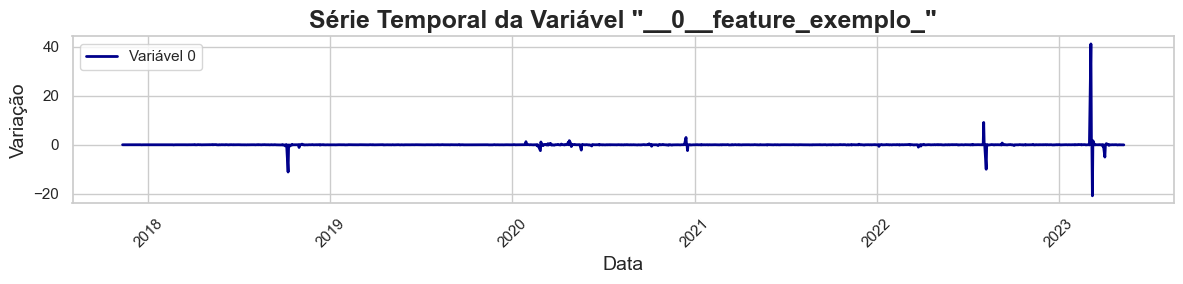

In [159]:
grafico_linha(df_price, 0, title='Série Temporal da Variável "__0__feature_exemplo_"', xlabel='Data', ylabel='Variação', label='Variável 0')

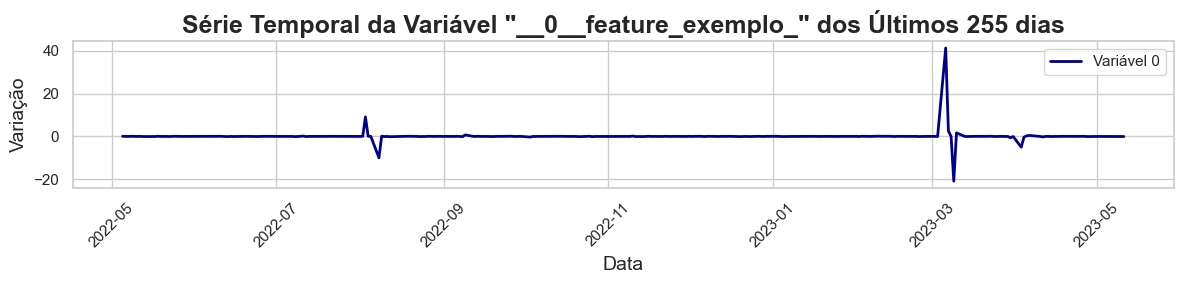

In [160]:
grafico_linha(df_price.tail(255), 0, title='Série Temporal da Variável "__0__feature_exemplo_" dos Últimos 255 dias', xlabel='Data', ylabel='Variação', label='Variável 0')

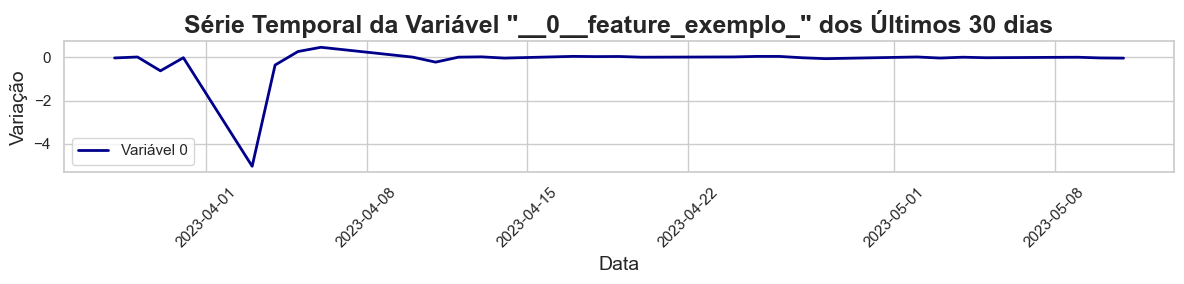

In [161]:
grafico_linha(df_price.tail(30), 0, title='Série Temporal da Variável "__0__feature_exemplo_" dos Últimos 30 dias', xlabel='Data', ylabel='Variação', label='Variável 0')

In [162]:
df_price[0].describe()

count    1364.000000
mean        0.003569
std         1.359499
min       -20.869534
25%        -0.019537
50%         0.000000
75%         0.020019
max        41.230773
Name: 0, dtype: float64

In [163]:
print('Quantidade de Dados Perdidos da Variável 0: ', int(df_price[0].isnull().sum()))

Quantidade de Dados Perdidos da Variável 0:  130


### Separando a base de dados em 50% treino e teste

In [164]:
split_index = round(len(df_price) * 0.50)
dados_treino = df_price.iloc[:split_index].dropna()
dados_teste = df_price.iloc[split_index:].dropna() # <-!

Dados treino

In [165]:
print(f'Start: {str(dados_treino.index[0])[:10]}')
print(f'End: {str(dados_treino.index[-1])[:10]}')
print(f'Quantidade de Dados: {len(dados_treino)}')

Start: 2017-11-10
End: 2020-05-08
Quantidade de Dados: 617


Dados teste

In [166]:
print(f'Start: {str(dados_teste.index[0])[:10]}')
print(f'End: {str(dados_teste.index[-1])[:10]}')
print(f'Quantidade de Dados: {len(dados_teste)}')

Start: 2020-05-11
End: 2023-05-10
Quantidade de Dados: 746


### Predição

In [167]:
# Nome da coluna
features = [0, 1]

x_treino = dados_treino[features]
y_treino = dados_treino['alvo_binario']

x_teste = dados_teste[features]
y_teste = dados_teste['alvo_binario']

decision_tree_classifier = DecisionTreeClassifier(criterion='gini', max_depth=3)

decision_tree_classifier.fit(x_treino, y_treino)

DecisionTreeClassifier(max_depth=3)

In [168]:
y_predicao_treino = decision_tree_classifier.predict(x_treino)
y_predicao_teste = decision_tree_classifier.predict(x_teste)

dados_treino['predicao'] = y_predicao_treino
dados_teste['predicao'] = y_predicao_teste

### Resultados

In [169]:
dados_treino['predicao'].value_counts()

predicao
0.0    471
1.0    146
Name: count, dtype: int64

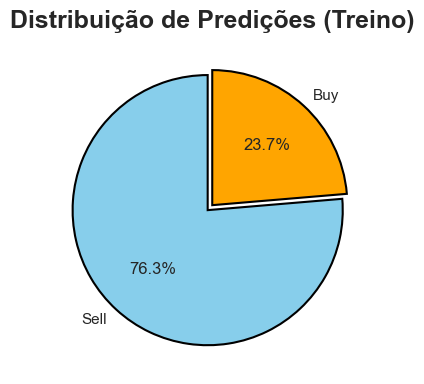

In [170]:
grafico_sinais(dados_treino, 'Distribuição de Predições (Treino)')

In [171]:
dados_teste['predicao'].value_counts()

predicao
0.0    597
1.0    149
Name: count, dtype: int64

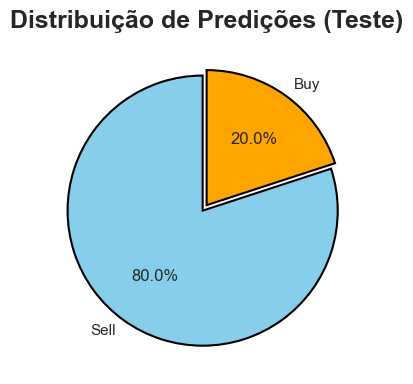

In [172]:
grafico_sinais(dados_teste, 'Distribuição de Predições (Teste)')

In [173]:
def calcula_resultado(dados):
    resultado = []
    for predicao, alvo, alvo_numerico in list(dados[['predicao', 'alvo_binario', 'alvo_numerico']].values):
        if predicao == alvo:
            resultado.append(abs(alvo_numerico))
        else:
            resultado.append(-abs(alvo_numerico))
    dados['serie_retorno'] = resultado
    return dados

In [174]:
# Definindo a quantidade de contratos
quantidade_de_contratos = 100

In [175]:
dados_treino = calcula_resultado(dados_treino)
dados_treino['retorno_acumulado'] = dados_treino['serie_retorno'].cumsum() * quantidade_de_contratos
dados_treino.tail(3)

,Adj Close,Close,High,Low,Open,Volume,variacao_percentual,alvo_numerico,alvo_binario,0,1,predicao,serie_retorno,retorno_acumulado
Date,,,,,,,,,,,,,,
2020-05-06,14.77,14.77,15.26,14.45,15.12,7210900,-0.025726,-1.550000,0.0,0.026130,0.019292,0.0,1.550000,9206.998539
2020-05-07,13.66,13.66,15.26,13.65,15.21,15424200,-0.075152,-0.339999,0.0,0.065234,0.181936,0.0,0.339999,9240.998459
2020-05-08,13.60,13.60,14.20,13.45,13.94,11318500,-0.004392,-0.350000,0.0,0.004386,0.028700,0.0,0.350000,9275.998497


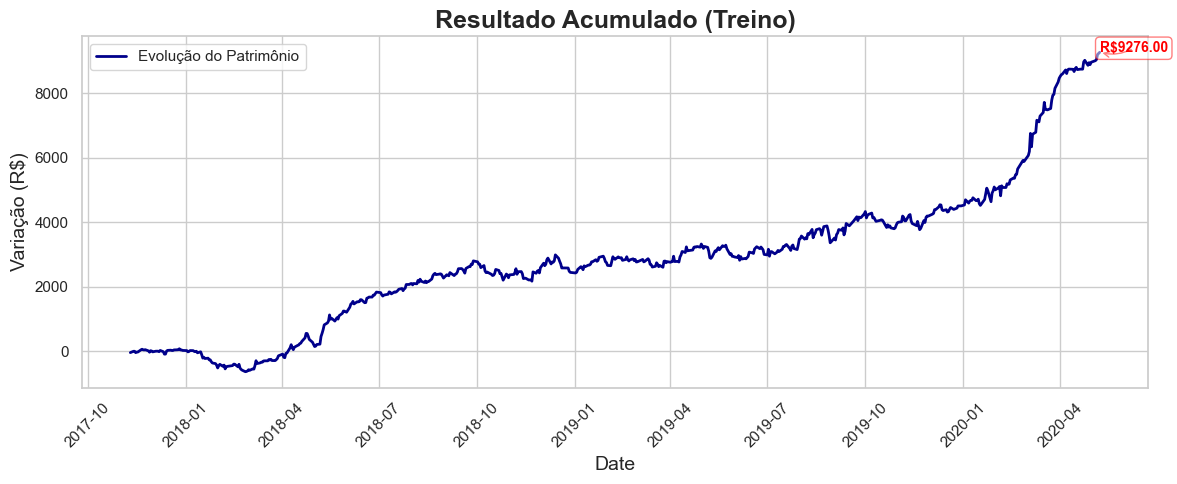

In [176]:
grafico_retorno(dados_treino, 'retorno_acumulado', 'Resultado Acumulado (Treino)', 'Date', 'Variação (R$)', 'Evolução do Patrimônio', figsize=(12, 5))

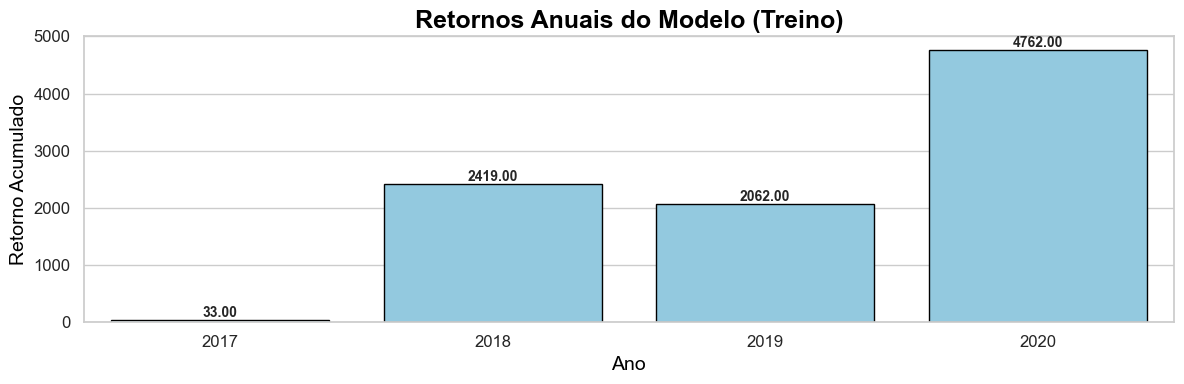

In [177]:
grafico_retorno_anual(dados_treino, 'serie_retorno', 'Retornos Anuais do Modelo (Treino)', quantidade_de_contratos=quantidade_de_contratos)

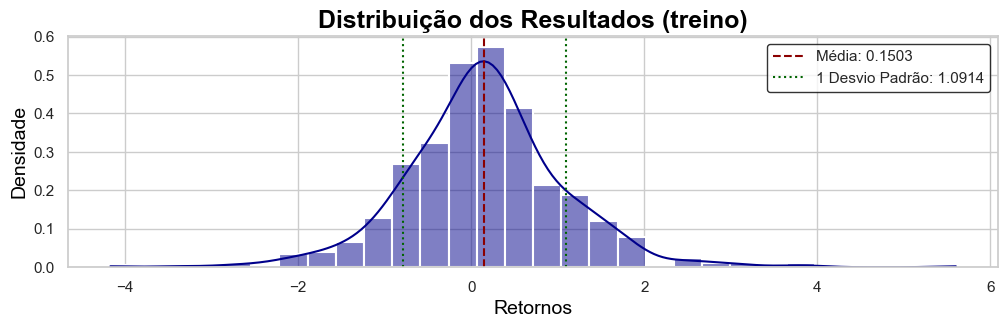

In [178]:
grafico_KDE(dados_treino, 'serie_retorno', 'Distribuição dos Resultados (treino)', 'Retornos')

In [179]:
dados_teste = calcula_resultado(dados_teste)
dados_teste['retorno_acumulado'] = dados_teste['serie_retorno'].cumsum() * quantidade_de_contratos
dados_teste.tail(3)

,Adj Close,Close,High,Low,Open,Volume,variacao_percentual,alvo_numerico,alvo_binario,0,1,predicao,serie_retorno,retorno_acumulado
Date,,,,,,,,,,,,,,
2023-05-08,11.72,11.72,12.11,11.65,11.71,9554900,0.007739,0.10,1.0,-0.008869,0.001599,1.0,0.10,1088.000536
2023-05-09,11.77,11.77,11.99,11.57,11.67,11598000,0.004266,0.54,1.0,-0.004262,-0.001495,0.0,-0.54,1034.000540
2023-05-10,12.29,12.29,12.33,11.75,11.75,15418500,0.044180,0.66,1.0,-0.036728,-0.007532,0.0,-0.66,968.000555


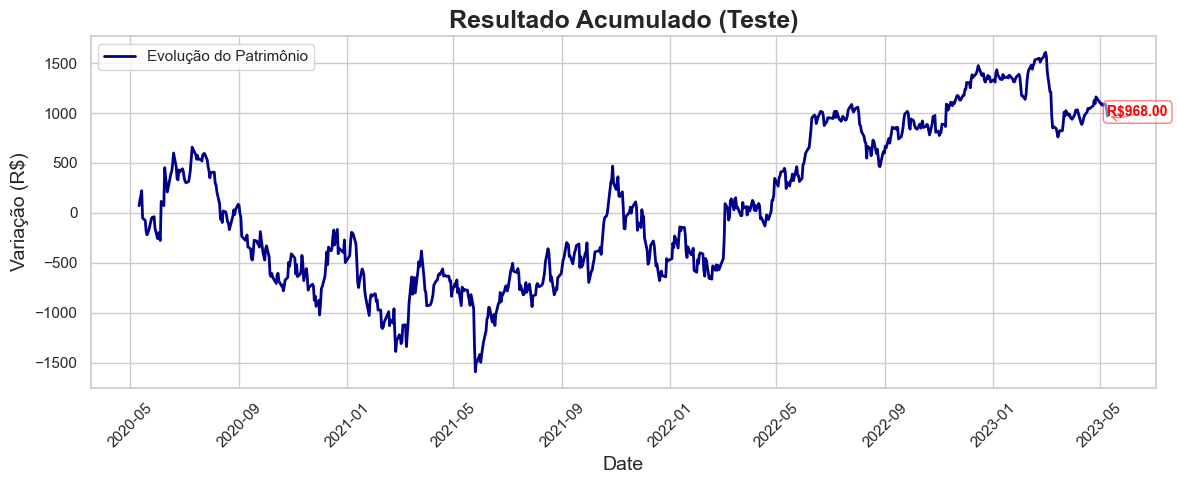

In [180]:
grafico_retorno(dados_teste, 'retorno_acumulado', 'Resultado Acumulado (Teste)', 'Date', 'Variação (R$)', 'Evolução do Patrimônio', figsize=(12, 5))

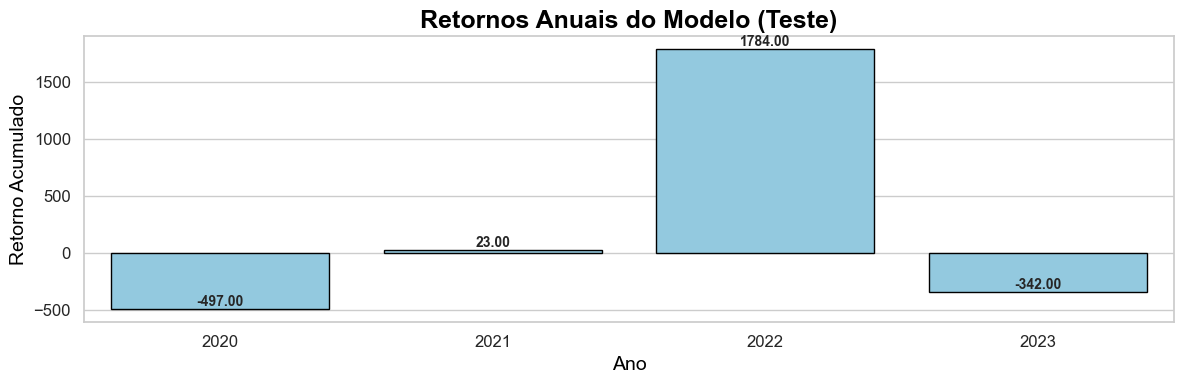

In [181]:
grafico_retorno_anual(dados_teste, 'serie_retorno', 'Retornos Anuais do Modelo (Teste)', quantidade_de_contratos=quantidade_de_contratos)

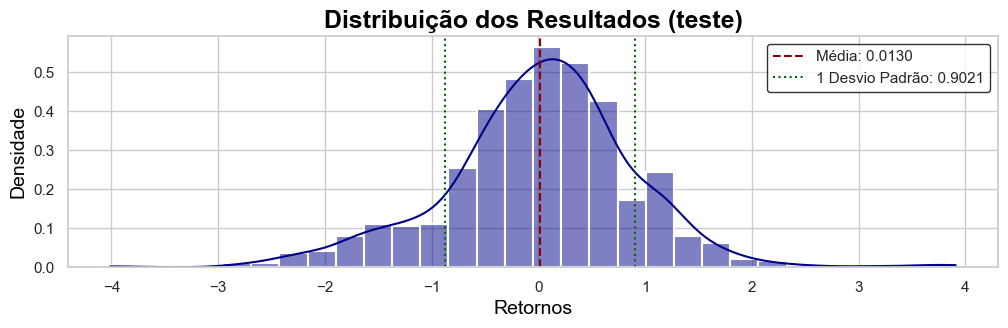

In [182]:
grafico_KDE(dados_teste, 'serie_retorno', 'Distribuição dos Resultados (teste)', 'Retornos')

### Dados Estatísticos

In [196]:
print(f'Acurácia Treino: {metrics.accuracy_score(y_treino, y_predicao_treino):.3f}')
print(f'Acurácia Teste: {metrics.accuracy_score(y_teste, y_predicao_teste):.3f}')
print()
print(f'Média dos Retornos Diários Treino: {dados_treino["serie_retorno"].mean() * quantidade_de_contratos:.3f}')
print(f'Média dos Retornos Diários Teste: {dados_teste["serie_retorno"].mean() * quantidade_de_contratos:.3f}')

Acurácia Treino: 0.593
Acurácia Teste: 0.539

Média dos Retornos Diários Treino: 15.034
Média dos Retornos Diários Teste: 1.298


### Estrutura da Matriz de Confusão

A matriz de confusão para **classificação binária** tem a seguinte forma:

|                         | **Predito: Negativo (0)** | **Predito: Positivo (1)** |
|-------------------------|---------------------------|---------------------------|
| **Real: Negativo (0)**  | **Verdadeiros Negativos (TN)** | **Falsos Positivos (FP)** |
| **Real: Positivo (1)**  | **Falsos Negativos (FN)** | **Verdadeiros Positivos (TP)** |

### Explicação das Células:
- **Verdadeiros Negativos (TN)**: São os casos em que o modelo corretamente previu a classe negativa. Ou seja, o modelo previu "0" e o valor real era "0".
- **Falsos Positivos (FP)**: São os casos em que o modelo previu a classe positiva incorretamente. Ou seja, o modelo previu "1" quando o valor real era "0".
- **Falsos Negativos (FN)**: São os casos em que o modelo previu a classe negativa incorretamente. Ou seja, o modelo previu "0" quando o valor real era "1".
- **Verdadeiros Positivos (TP)**: São os casos em que o modelo corretamente previu a classe positiva. Ou seja, o modelo previu "1" e o valor real era "1".

### Exemplo de Matriz de Confusão

Suponha que você tenha o seguinte conjunto de predições:

| **Real/Predito**  | **Negativo (0)** | **Positivo (1)** |
|-------------------|------------------|------------------|
| **Negativo (0)**  | 50               | 10               |
| **Positivo (1)**  | 5                | 100              |

A matriz de confusão seria:

|                         | **Predito: Negativo (0)** | **Predito: Positivo (1)** |
|-------------------------|---------------------------|---------------------------|
| **Real: Negativo (0)**  | 50 (TN)                  | 10 (FP)                  |
| **Real: Positivo (1)**  | 5 (FN)                   | 100 (TP)                 |

### Como interpretar a matriz de confusão:
- **50 (TN)**: O modelo previu "0" (Negativo) e o valor real era "0". O modelo fez 50 acertos para a classe negativa.
- **10 (FP)**: O modelo previu "1" (Positivo), mas o valor real era "0". O modelo cometeu 10 erros, classificando como positivo algo que era negativo.
- **5 (FN)**: O modelo previu "0" (Negativo), mas o valor real era "1". O modelo cometeu 5 erros, classificando como negativo algo que era positivo.
- **100 (TP)**: O modelo previu "1" (Positivo) e o valor real era "1". O modelo fez 100 acertos para a classe positiva.


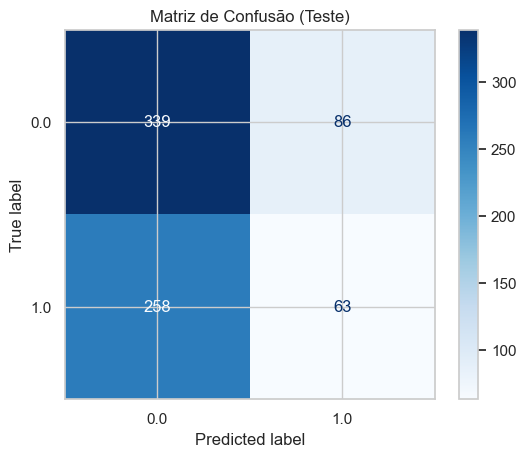

In [193]:
matriz_confusao = confusion_matrix(y_teste, y_predicao_teste)
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao, display_labels=decision_tree_classifier.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Matriz de Confusão (Teste)")
plt.show()

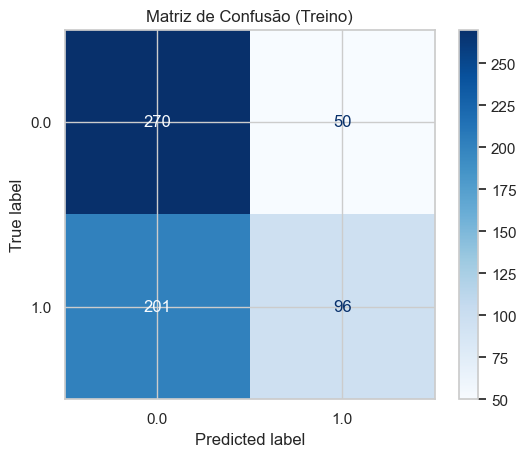

In [192]:
matriz_confusao = confusion_matrix(y_treino, y_predicao_treino)
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao, display_labels=decision_tree_classifier.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Matriz de Confusão (Treino)")
plt.show()

### Classification Report

### 1. **Precision, Recall e F1-Score para cada classe (0 e 1)**:

- **Classe 0 (Negativo)**:
  - **Precision (Precisão)**: `0.57`  
    - Significa que 57% das previsões de classe 0 estavam corretas. Ou seja, das vezes em que o modelo previu a classe 0, 57% estavam corretas.
  - **Recall (Sensibilidade)**: `0.80`  
    - Significa que o modelo identificou corretamente 80% de todos os casos reais de classe 0. Ou seja, das vezes em que a classe real era 0, o modelo acertou em 80% dos casos.
  - **F1-Score**: `0.66`  
    - A média harmônica entre precisão e recall. Um valor de 0.66 indica um equilíbrio entre os dois, mas com um recall mais forte do que a precisão.

- **Classe 1 (Positivo)**:
  - **Precision (Precisão)**: `0.42`  
    - Significa que 42% das previsões de classe 1 estavam corretas. Ou seja, das vezes em que o modelo previu a classe 1, 42% estavam corretas.
  - **Recall (Sensibilidade)**: `0.20`  
    - Significa que o modelo identificou corretamente 20% de todos os casos reais de classe 1. Ou seja, das vezes em que a classe real era 1, o modelo acertou em 20% dos casos.
  - **F1-Score**: `0.27`  
    - A média harmônica entre precisão e recall. Um valor de 0.27 indica que o modelo teve dificuldades em identificar a classe 1 de forma eficaz.

### 2. **Accuracy (Acurácia)**:
- **Acurácia**: `0.54`  
  - Indica a proporção de previsões corretas no total, considerando todas as classes (0 e 1).
  - O modelo acertou 54% de todas as previsões. Isso indica que o modelo tem um desempenho geral abaixo da média.

### 3. **Macro Average (Média Macro)**:
- **Média Macro**:
  - A média das métricas de **precisão**, **recall** e **F1-Score** calculadas para todas as classes, sem considerar o número de amostras em cada classe.
  - **Precision (Macro)**: `0.50`  
  - **Recall (Macro)**: `0.50`  
  - **F1-Score (Macro)**: `0.47`  
  - A média macro trata as classes igualmente, sem levar em conta o número de instâncias de cada uma. Nesse caso, a média das métricas de precisão, recall e F1-Score para as duas classes é baixa.

### 4. **Weighted Average (Média Ponderada)**:
- **Média Ponderada**:
  - A média das métricas de **precisão**, **recall** e **F1-Score**, mas ponderada pelo número de instâncias de cada classe.
  - **Precision (Ponderada)**: `0.51`  
  - **Recall (Ponderada)**: `0.54`  
  - **F1-Score (Ponderada)**: `0.49`  
  - A média ponderada leva em conta o número de amostras em cada classe, o que faz com que o desempenho da classe maior tenha mais impacto no valor final.

### **Resumo da Interpretação**:
- **Precision** e **Recall** nos ajudam a entender o desempenho do modelo para cada classe:
  - A **Precisão** indica a exatidão das previsões, enquanto o **Recall** indica a capacidade de detectar todos os casos positivos reais.
  - O **F1-Score** é uma combinação das duas, útil para entender o equilíbrio entre precisão e recall.
  
- A **Acurácia** fornece uma visão geral, mas não é a melhor métrica quando as classes estão desbalanceadas. Neste caso, a acurácia do modelo é de 54%, o que é baixo.

- A **Média Macro** é uma boa medida quando se deseja tratar todas as classes igualmente, enquanto a **Média Ponderada** é mais indicada quando se quer dar mais peso às classes com mais instâncias.


In [ ]:
relatorio = classification_report(y_teste, y_predicao_teste)
print(relatorio)


              precision    recall  f1-score   support

         0.0       0.57      0.80      0.66       425
         1.0       0.42      0.20      0.27       321

    accuracy                           0.54       746
   macro avg       0.50      0.50      0.47       746
weighted avg       0.51      0.54      0.49       746



In [200]:
relatorio = classification_report(y_treino, y_predicao_treino)
print(relatorio)


              precision    recall  f1-score   support

         0.0       0.57      0.84      0.68       320
         1.0       0.66      0.32      0.43       297

    accuracy                           0.59       617
   macro avg       0.62      0.58      0.56       617
weighted avg       0.61      0.59      0.56       617



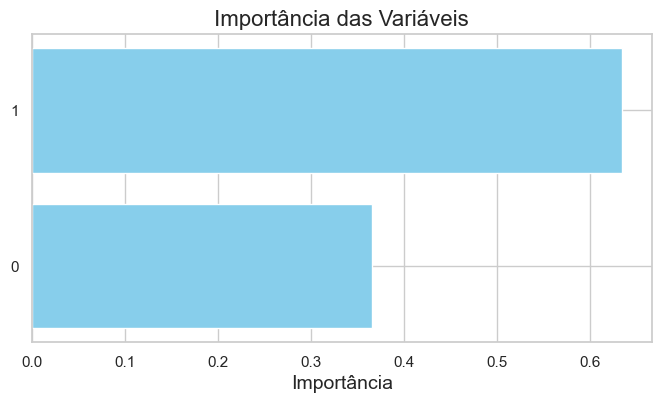

In [187]:
importances = decision_tree_classifier.feature_importances_

plt.figure(figsize=(8, 4))
plt.barh(range(len(features)), importances, color='skyblue')
plt.yticks(range(len(features)), [str(f) for f in features])
plt.xlabel("Importância", fontsize=14)
plt.title("Importância das Variáveis", fontsize=16)
plt.show()
